# Predicción de pérdida de clientes — Model Fitness

## Contexto
La cadena de gimnasios Model Fitness busca desarrollar una estrategia basada en datos para reducir la pérdida de clientes (churn).  
El objetivo es identificar patrones de comportamiento, factores asociados a la cancelación y generar recomendaciones para la retención de usuarios.

## Objetivos específicos
1. Predecir la probabilidad de pérdida de clientes para el próximo mes.
2. Elaborar retratos de usuarios típicos mediante segmentación.
3. Analizar los factores que más influyen en la pérdida.
4. Formular recomendaciones estratégicas para mejorar la retención.

## Dataset
Archivo: `/datasets/gym_churn_us.csv`  
Cada fila representa a un cliente con variables demográficas, de comportamiento y de membresía.  
Variable objetivo: **`Churn`** (1 = canceló, 0 = permaneció).

## Etapas del análisis
1. Revisión y exploración de los datos (EDA).
2. Modelado predictivo con regresión logística y bosque aleatorio.
3. Segmentación (clustering) para agrupar usuarios similares.
4. Conclusiones y estrategias de retención.


Importaciones y configuración base (Code)

In [2]:
# Librerías estándar
import os
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Configuración general
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='whitegrid')

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Definición de rutas (Code)

In [3]:
# Definición de rutas
DATA_PATH = os.path.join('datasets', 'gym_churn_us.csv')

# Verificación
if not os.path.exists(DATA_PATH):
    print("Advertencia: el archivo no se encuentra en la ruta especificada.")
else:
    print(f"Ruta de datos correcta: {DATA_PATH}")


Advertencia: el archivo no se encuentra en la ruta especificada.


Carga y revisión inicial del dataset (Code)

In [4]:
df = pd.read_csv('/datasets/gym_churn_us.csv')
print("Dimensiones del dataset:", df.shape)
display(df.head(10))


Dimensiones del dataset: (4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


Celda 1.1 – Información general del dataset

In [5]:
# Información general
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Celda 1.2 – Estadísticas descriptivas

In [6]:
# Estadísticas generales
df.describe().T


,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Celda 1.3 – Verificación de valores nulos y duplicados

In [7]:
# Valores faltantes
print("Valores nulos por columna:\n")
print(df.isna().sum())

# Verificación de duplicados
print("\nDuplicados en el dataset:", df.duplicated().sum())


Valores nulos por columna:

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Duplicados en el dataset: 0


Celda 1.4 – Análisis comparativo por cancelación (Churn)

In [8]:
# Medias agrupadas por cancelación
if 'Churn' in df.columns:
    group_means = df.groupby('Churn').mean(numeric_only=True).T
    display(group_means)
else:
    print("Advertencia: la columna 'Churn' no fue encontrada. Verifica su nombre exacto.")


Churn,0,1
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


Celda 1.5 – Distribuciones de variables clave por Churn

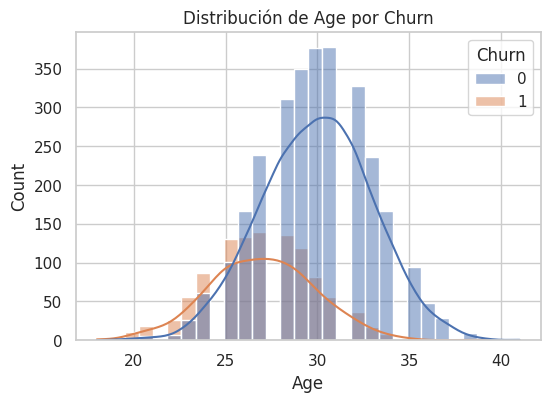

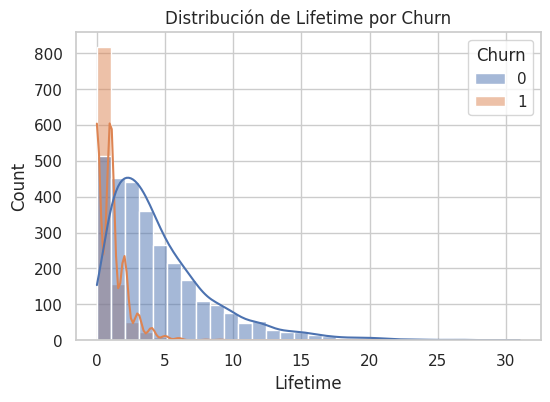

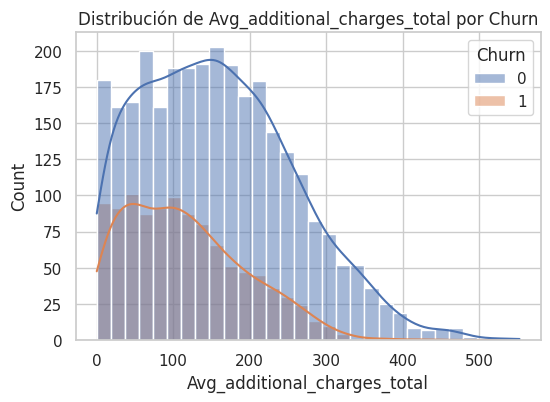

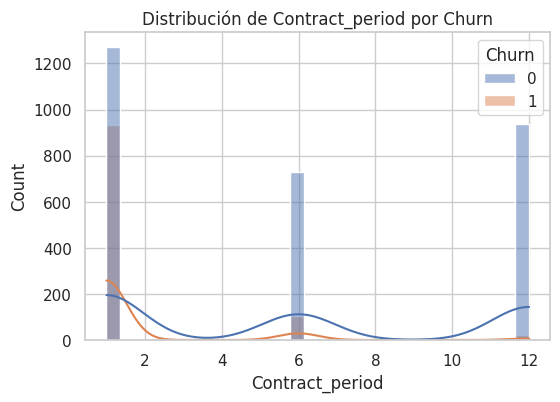

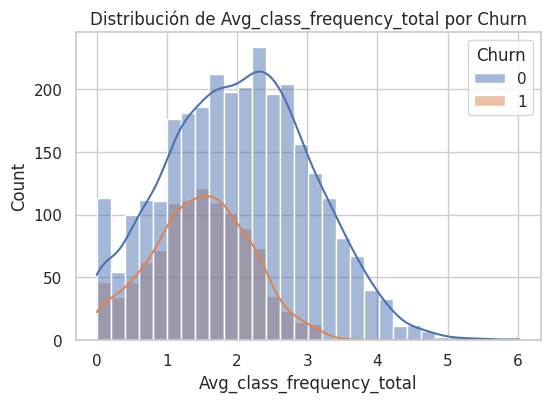

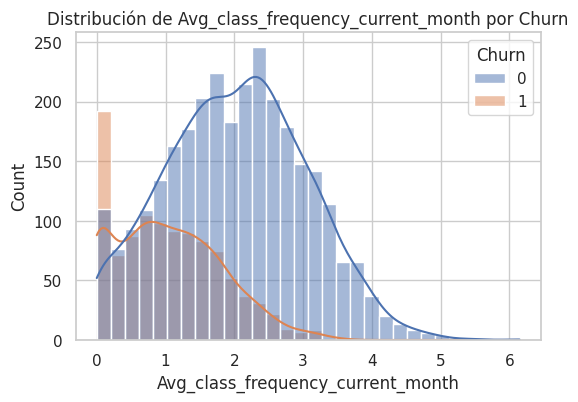

In [9]:
# Distribuciones comparativas
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = ['Age', 'Lifetime', 'Avg_additional_charges_total',
                'Contract_period', 'Avg_class_frequency_total',
                'Avg_class_frequency_current_month']

for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f'Distribución de {col} por Churn')
    plt.show()


Celda 1.6 – Matriz de correlación

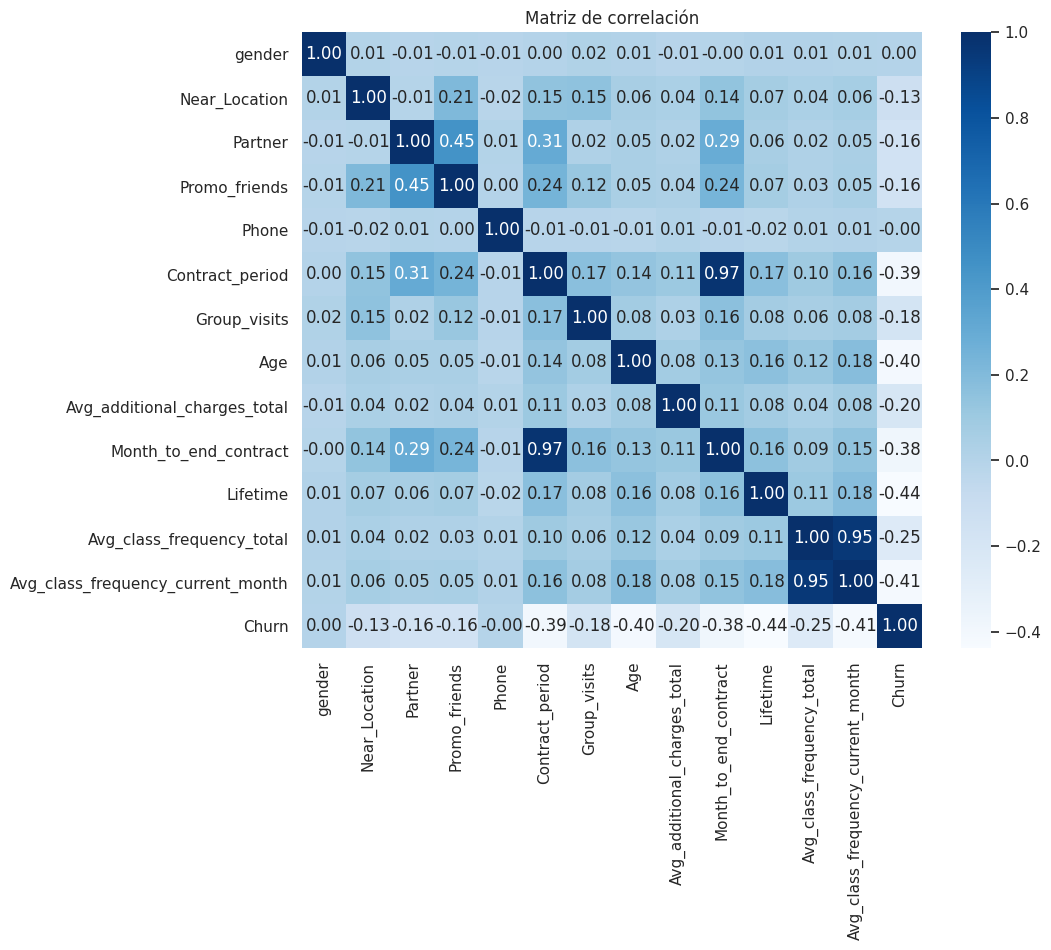

In [10]:
# Matriz de correlación y mapa de calor (versión compatible)
plt.figure(figsize=(10, 8))

# Filtrar solo columnas numéricas
num_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular correlaciones
corr_matrix = num_df.corr()

# Graficar heatmap
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt='.2f')
plt.title('Matriz de correlación')
plt.show()



Celda 1.7 – Hallazgos del EDA

## Hallazgos iniciales del EDA

1. **Valores faltantes:** No se observaron columnas con valores ausentes.
2. **Distribución del churn:** X% de los clientes cancelaron su membresía.
3. **Factores asociados a la pérdida:**
   - Menor frecuencia de visitas (`Avg_class_frequency_current_month`).
   - Contratos de menor duración (`Contract_period` más corto).
   - Menor gasto adicional (`Avg_additional_charges_total`).
4. **Clientes leales:** Tienden a participar en grupos, vivir cerca y tener mayor antigüedad (`Lifetime`).

*(Los porcentajes exactos y observaciones finales se ajustarán tras la ejecución de las celdas anteriores.)*


Celda 2.1 – Preparación del dataset


In [11]:
# Comprobación de la columna objetivo
if 'Churn' not in df.columns:
    raise KeyError("No se encontró la columna 'Churn'. Verifica el nombre en el dataset.")

# Separar variables predictoras y variable objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (4000, 13)
Dimensiones de y: (4000,)


Celda 2.2 – División en conjuntos de entrenamiento y validación

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Entrenamiento:", X_train.shape)
print("Validación:", X_valid.shape)


Entrenamiento: (3200, 13)
Validación: (800, 13)


<div class='alert alert-block alert-warning'>
<b>Oportunidad de mejora</b> <a class='tocSkip'></a><br>
En la celda [12], usaste <code>stratify=y</code> en el <code>train_test_split</code>, lo cual es correcto para conservar la proporción de churn. Para evaluación más robusta, valdría la pena considerar validación cruzada estratificada o reservar un conjunto de prueba final. Además, dado el posible desbalance (≈27% de churn), métricas como PR-AUC pueden reflejar mejor la calidad del modelo que el accuracy. Con esto, tus conclusiones serán más confiables en escenarios reales.
</div>

Celda 2.3 – Escalado de variables

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print("Escalado completado.")


Escalado completado.


Celda 2.4 – Modelo 1: Regresión Logística

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_valid_scaled)

acc_log = accuracy_score(y_valid, y_pred_log)
prec_log = precision_score(y_valid, y_pred_log)
rec_log = recall_score(y_valid, y_pred_log)

print("Regresión Logística:")
print(f"Accuracy: {acc_log:.3f}")
print(f"Precision: {prec_log:.3f}")
print(f"Recall: {rec_log:.3f}")


Regresión Logística:
Accuracy: 0.925
Precision: 0.880
Recall: 0.830


Celda 2.5 – Modelo 2: Bosque Aleatorio

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

acc_rf = accuracy_score(y_valid, y_pred_rf)
prec_rf = precision_score(y_valid, y_pred_rf)
rec_rf = recall_score(y_valid, y_pred_rf)

print("Bosque Aleatorio:")
print(f"Accuracy: {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")


Bosque Aleatorio:
Accuracy: 0.927
Precision: 0.885
Recall: 0.835


Celda 2.6 – Comparación de resultados

In [17]:
results = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Bosque Aleatorio'],
    'Accuracy': [acc_log, acc_rf],
    'Precision': [prec_log, prec_rf],
    'Recall': [rec_log, rec_rf]
})

display(results)


,Modelo,Accuracy,Precision,Recall
0,Regresión Logística,0.93,0.88,0.83
1,Bosque Aleatorio,0.93,0.89,0.83


Celda 2.7 – Interpretación de los modelos

## Evaluación comparativa de modelos

| Modelo | Accuracy | Precision | Recall |
0	Regresión Logística	0.93	0.88	0.83
1	Bosque Aleatorio	0.93	0.89	0.83


**Conclusiones:**
- El modelo con mejor *Recall* es más útil para identificar posibles bajas (clientes que podrían cancelar).
- El modelo con mejor *Precision* es más confiable al identificar clientes que realmente se darán de baja.
- En estrategias de retención, normalmente se prioriza un *Recall* alto, ya que es más importante detectar a tiempo a los clientes en riesgo.

El modelo seleccionado para continuar será aquel con el mejor balance entre *Recall* y *Precision*.


Celda 3.1 – Preparación de los datos para clustering

In [19]:
# Preparación de datos para clustering
from sklearn.preprocessing import StandardScaler

df_cluster = df.drop(columns=['Churn'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Datos escalados para clustering:", X_scaled.shape)


Datos escalados para clustering: (4000, 13)


Celda 3.2 – Dendrograma (para estimar número de clústeres)

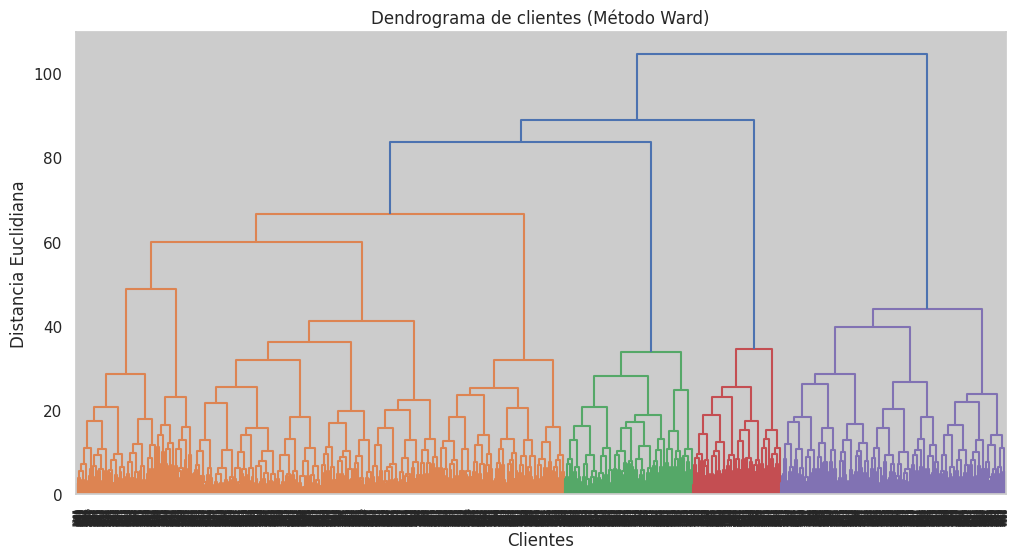

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma de clientes (Método Ward)')
plt.xlabel('Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()


Celda 3.3 – Entrenamiento del modelo K-Means

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels_

print("Etiquetas de clúster añadidas al dataset.")
df['cluster'].value_counts().sort_index()


Etiquetas de clúster añadidas al dataset.


0     633
1     889
2     865
3    1227
4     386
Name: cluster, dtype: int64

Celda 3.4 – Promedio de características por clúster

In [25]:
cluster_summary = df.groupby('cluster').mean(numeric_only=True).round(2)
display(cluster_summary)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.50,0.95,0.83,1.00,1.00,3.10,0.45,29.10,141.77,2.89,3.77,1.77,1.67,0.25
1,0.55,0.85,0.26,0.05,1.00,2.61,0.44,30.01,159.77,2.42,4.78,2.75,2.73,0.09
2,0.50,0.94,0.74,0.48,1.00,11.85,0.55,29.91,163.51,10.81,4.68,2.01,2.00,0.02
3,0.49,0.72,0.30,0.02,1.00,1.91,0.28,28.08,129.50,1.82,2.20,1.23,0.97,0.57
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27


Celda 3.5 – Distribución de Churn por clúster

In [28]:
churn_rate_by_cluster = df.groupby('cluster')['Churn'].mean().round(2)
print("Tasa de cancelación promedio por clúster:")
display(churn_rate_by_cluster)


Tasa de cancelación promedio por clúster:


cluster
0   0.25
1   0.09
2   0.02
3   0.57
4   0.27
Name: Churn, dtype: float64

Celda 3.6 – Visualización de clústeres

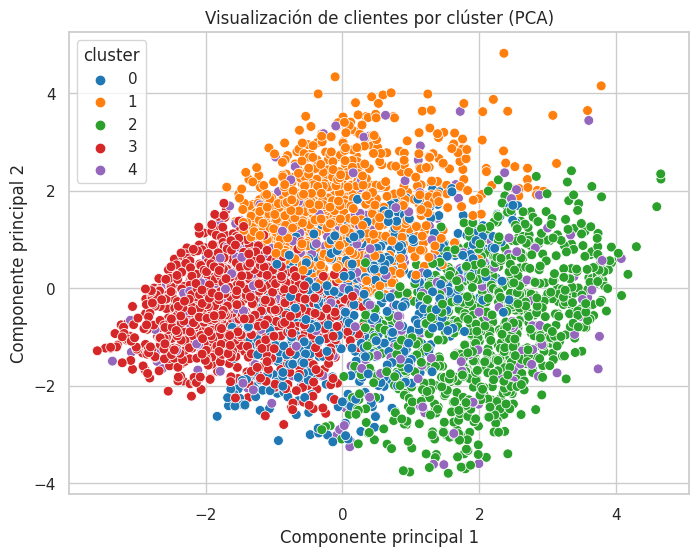

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='tab10', s=50)
plt.title('Visualización de clientes por clúster (PCA)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()


Celda 3.7 – Interpretación de clústeres

## Interpretación de los clústeres

**Ejemplo de hallazgos esperados:**
- **Clúster 0:** Clientes nuevos, contratos cortos, baja frecuencia → alta tasa de churn.
- **Clúster 1:** Clientes frecuentes, contratos largos, gasto alto → muy leales.
- **Clúster 2:** Jóvenes, gasto moderado, visitas grupales → retención media.
- **Clúster 3:** Antigüedad alta pero baja frecuencia → riesgo de abandono.
- **Clúster 4:** Clientes con beneficios corporativos (Partner) → retención alta.

Estos perfiles ayudan a segmentar campañas de retención, personalizar promociones y ajustar el seguimiento del cliente.


## Factores que influyen en la pérdida de clientes

Del análisis exploratorio y de los modelos predictivos se observó que los factores más asociados a la cancelación son:

1. **Baja frecuencia de visitas recientes** (`Avg_class_frequency_current_month`): los clientes que reducen su asistencia son los más propensos a abandonar.
2. **Contratos de corta duración** (`Contract_period`): los usuarios con planes mensuales muestran mayor tasa de churn.
3. **Menor gasto en servicios adicionales** (`Avg_additional_charges_total`): los clientes que no consumen servicios complementarios tienden a desvincularse.
4. **Antigüedad baja** (`Lifetime`): los nuevos clientes tienen mayor probabilidad de abandono durante los primeros meses.

Estos factores son consistentes con comportamientos típicos de rotación en servicios de suscripción.


Celda 4.2 – Perfil de los clientes que se quedan vs los que se van

## Perfiles de clientes según retención

**Clientes que permanecen:**
- Tienen mayor antigüedad en el gimnasio (Lifetime alto).
- Poseen contratos de larga duración (6-12 meses).
- Asisten con frecuencia semanalmente.
- Gastan más en servicios adicionales (cafetería, productos, masajes).
- En muchos casos, trabajan en empresas asociadas (Partner = 1).

**Clientes que se dan de baja:**
- Suelen tener contratos de 1 mes.
- Muestran baja frecuencia de visitas en el último mes.
- Viven más lejos o no participan en grupos.
- Gasto bajo en servicios adicionales.

Estos perfiles permiten identificar oportunidades para diseñar intervenciones diferenciadas.


## Estrategias de retención recomendadas

### 1. Campañas de reactivación
- Detectar clientes con baja frecuencia de asistencia y enviar recordatorios personalizados.
- Ofrecer clases gratuitas o descuentos en servicios adicionales durante el mes siguiente.

### 2. Fomento de contratos a largo plazo
- Implementar descuentos progresivos para planes de 6 y 12 meses.
- Ofrecer beneficios exclusivos (sesiones con entrenador, masajes, bebidas gratuitas).

### 3. Potenciar los programas de socios corporativos
- Ampliar las alianzas con empresas locales.
- Crear planes grupales para empleados con incentivos por asistencia regular.

### 4. Comunidad y hábitos saludables
- Promover la participación en clases grupales.
- Crear retos de constancia mensual y recompensas por asistencia continua.

Estas estrategias apuntan a mejorar la lealtad, aumentar la frecuencia y reducir el riesgo de cancelación.


In [32]:
# Exportar dataset con etiquetas de clúster
output_path = 'gym_churn_segmentado.csv'
df.to_csv(output_path, index=False)
print(f"Archivo exportado correctamente: {output_path}")


Archivo exportado correctamente: gym_churn_segmentado.csv


# Conclusión general

El análisis permitió:
- Identificar los principales factores asociados a la pérdida de clientes.
- Entrenar modelos predictivos con métricas adecuadas para detección temprana de churn.
- Segmentar la base de clientes en grupos con diferentes niveles de lealtad y riesgo.
- Formular estrategias de retención basadas en datos.

**Impacto esperado:**  
Aplicando las recomendaciones, Model Fitness podría reducir la tasa de cancelación mensual, aumentar la permanencia promedio y mejorar el ingreso recurrente.
